# Cab-Driver Agent

## Problem Statement

`You are hired as a Sr. Machine Learning Er. at SuperCabs, a leading app-based cab provider in a large Indian metro city. In this highly competitive industry, retention of good cab drivers is a crucial business driver, and you believe that a sound RL-based system for assisting cab drivers can potentially retain and attract new cab drivers. `

 

`Cab drivers, like most people, are incentivised by a healthy growth in income. The goal of your project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.`

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver
import time

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
# shape of time matrix
print('Time-matrix Shape: ',Time_matrix.shape)
print('Time taken from location 2 to location 3 on 11 am on 5th day of the week: ', Time_matrix[2,3,11,5])

Time-matrix Shape:  (5, 5, 24, 7)
Time taken from location 2 to location 3 on 11 am on 5th day of the week:  2.0


In [4]:
state_action_temp_value_2=[]
for i in range(Time_matrix.shape[0]):
    for j in range(Time_matrix.shape[1]):
        for t in range(Time_matrix.shape[2]):
            for d in range(Time_matrix.shape[3]):
                if Time_matrix[i,j,t,d] == 2 and i!=j:
                    for k in range(1,Time_matrix.shape[0]+1):
                        state_action_temp_value_2.append(((k,t,d),(i+1,j+1)))
print('Number of actions with 2  time taken: ', len(state_action_temp_value_2[0:10]))
print(random.sample(state_action_temp_value_2,10))

Number of actions with 2  time taken:  10
[((5, 17, 6), (5, 2)), ((2, 22, 2), (5, 3)), ((2, 21, 5), (2, 4)), ((2, 0, 0), (5, 4)), ((4, 14, 4), (2, 5)), ((2, 3, 6), (2, 5)), ((3, 12, 5), (3, 2)), ((3, 11, 3), (5, 1)), ((1, 16, 0), (1, 4)), ((4, 3, 3), (4, 5))]


#### Tracking the state-action pairs for checking convergence


In [5]:
# Initialise Q_dictionart as 'Q_dict' and States_tracked as 'States_track' for convergence
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
# rewards_tracked = {(1,0,2):[],(2,6,3):[], (3,3,2): [], (5,11,6):[],(0,20,3):[],(1,20,3):[]} #select any 6 Q-values

In [6]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [((1,0,2),(2,1)),((2,6,3),(1,3)),((3,3,2),(4,2)),((5,11,6),(3,4)),((0,20,3),(1,3)), ((1,20,3),(1,3))]    #select any 6 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action]=[]         #this is an array which will have appended values of that state-action pair for every 200th episode         


In [7]:
# Defining a function to save the Q-dictionary as pickle file
def save_obj(obj,name):
    with open(name+'.pkl','wb') as f:           # 'b' appended to the mode opens the file in binary mode
        pickle.dump(obj,f,pickle.HIGHEST_PROTOCOL)

In [8]:
# This function will append latest Q-values of the 6 Q-values which are being tracked for checking convergence
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            encoded_state = env.state_encod_arch1(state)
            encoded_state = encoded_state.reshape((1,agent.state_size))   # reshaping for passing it to NN model
            pred = agent.model.predict(encoded_state)
            action_idx = env.action_space.index(list(action))
            Q_val = pred[0][action_idx]
            States_track[state][action].append(Q_val)  
            

In [9]:
initialise_tracking_states()

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [10]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.action_space = env.action_space

        # Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01      
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.00003
        self.epsilon_min = 0.0
        self.epsilon = self.epsilon_max
        self.batch_size = 32    
        self.time_step=0
        # create replay memory using deque
        self.memory = deque(maxlen=2000)            # replay buffer memory(double ended) of size 2000

        # create main model and target model
        self.model = self.build_model()


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        
        # Hidden layers
        model.add(Dense(32,input_dim = self.state_size, activation = 'relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation = 'relu', kernel_initializer= 'he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        # compile model
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary                  # model summary
        return model



    def get_action(self, state):
        # get action from model using epsilon-greedy policy
        if np.random.rand() <= self.epsilon:                     # exploration: randomly choosing an action
            # select random action
            actions= env.requests(state)
            action = random.choice(actions)
        else:                                                   # exploitation: get action corresponding to max Q value for current state
            encoded_state = env.state_encod_arch1(state)
            encoded_state = encoded_state.reshape((1,self.state_size))        # reshaping it for passing it to neural network model
            q_value = self.model.predict(encoded_state)
            action_index = np.argmax(q_value)                              # index of max q value
            action = env.action_space[action_index]
        return action
    
    
    
    def decay_epsilon(self):
    # Decay in ε after we generate each sample from the environment
        self.time_step +=1
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp( - self.epsilon_decay * self.time_step)
        
            
    
    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
        
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_input = np.zeros((self.batch_size,self.state_size))
            update_output = np.zeros((self.batch_size,self.state_size))
            actions, rewards, terminal = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done = mini_batch[i]
                actions.append(self.action_space.index(action))
                rewards.append(reward)
                terminal.append(done)
                
                update_input[i]= env.state_encod_arch1(state)
                update_output[i]= env.state_encod_arch1(next_state)     
            # predict the target q value from state s 
            target = self.model.predict(update_input)
            # predict the target q value from state s' or next state
            target_qval = self.model.predict(update_output)
            
            for i in range(self.batch_size):
                if terminal[i]:                                # terminal state reached
                    target[i] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_qval[i]))
                    
            # model fit
            self.model.fit(update_input,target,batch_size=self.batch_size, epochs=1, verbose=0)
                    
    
    # load model weights
    def load(self,name):         
        self.model.load_weights(name)
                
                
    # save model
    def save(self, name):
        self.model.save_weights(name)

In [11]:
Episodes = 16000
m = 5 # number of cities, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1

### DQN block

In [12]:
# initialise environment 
env= CabDriver()
# state_size
state_size = m+t+d
action_size = len(env.action_space)      # get size of action from environment
agent = DQNAgent(state_size,action_size)
avg_reward = []                        # tracking average reward per episode
total_rewards  = []                     # tracking total rewards per episode


start_time = time.time()      # start time

for episode in range(Episodes):
    total_reward= 0
    done= False                          # terminal state not reached
    state= env.reset()
    time_step = 0
    
    while not done:
        
        # Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state)
        # Evaluate your reward and next state
        reward = env.reward_func(state, action,Time_matrix)
        next_state, done= env.next_state_func(state, action, Time_matrix)
        # Append the experience to the memory
        agent.append_sample(state, action, reward, next_state, done)
        agent.decay_epsilon()         # decay epsilon value for every time step
        # Train the model by calling function agent.train_model
        agent.train_model()
        total_reward+=reward
        state= next_state
        time_step+=1
        
        
        # Keep a track of rewards, Q-values, loss
        if done and episode%10==0:
            avg_reward.append(total_reward/time_step)
            total_rewards.append(total_reward)
            print("episode:", episode, "  score:", total_reward, "  memory length:",\
                  len(agent.memory), "  epsilon:", agent.epsilon,"   timestep:", time_step)
            
    if episode % 100 == 0:
        agent.save("./cab_driver.h5")
        
    if episode % 10 == 0:   #every 10th episode
        save_obj(avg_reward,'Rewards')   
        save_tracking_states()
        save_obj(States_track,'States_tracked') 
        
elapsed_time = time.time() - start_time  
print(elapsed_time)            
        

episode: 0   score: -153.0   memory length: 139   epsilon: 0.9958386823773029    timestep: 139
episode: 10   score: -378.0   memory length: 1623   epsilon: 0.9524763516057427    timestep: 162
episode: 20   score: -145.0   memory length: 2000   epsilon: 0.9141779800070414    timestep: 140
episode: 30   score: -189.0   memory length: 2000   epsilon: 0.8761832678961313    timestep: 137
episode: 40   score: -65.0   memory length: 2000   epsilon: 0.8418107941723271    timestep: 138
episode: 50   score: -113.0   memory length: 2000   epsilon: 0.8105112966708174    timestep: 135
episode: 60   score: -253.0   memory length: 2000   epsilon: 0.7803989622506644    timestep: 116
episode: 70   score: -216.0   memory length: 2000   epsilon: 0.7521721938958648    timestep: 129
episode: 80   score: -52.0   memory length: 2000   epsilon: 0.7240317745930429    timestep: 130
episode: 90   score: -344.0   memory length: 2000   epsilon: 0.6965052138529405    timestep: 125
episode: 100   score: 171.0   memo

episode: 840   score: 2150.0   memory length: 2000   epsilon: 0.0506260000336209    timestep: 96
episode: 850   score: 2166.0   memory length: 2000   epsilon: 0.04907085524261049    timestep: 114
episode: 860   score: 2221.0   memory length: 2000   epsilon: 0.047553494577466236    timestep: 98
episode: 870   score: 2010.0   memory length: 2000   epsilon: 0.04611762873573005    timestep: 103
episode: 880   score: 1658.0   memory length: 2000   epsilon: 0.044595157592942025    timestep: 127
episode: 890   score: 1948.0   memory length: 2000   epsilon: 0.04312294745541742    timestep: 111
episode: 900   score: 2159.0   memory length: 2000   epsilon: 0.04175817660643695    timestep: 98
episode: 910   score: 2290.0   memory length: 2000   epsilon: 0.04052160460762974    timestep: 95
episode: 920   score: 2041.0   memory length: 2000   epsilon: 0.039325189941695024    timestep: 100
episode: 930   score: 2065.0   memory length: 2000   epsilon: 0.038089752358351    timestep: 103
episode: 940  

episode: 1670   score: 2254.0   memory length: 2000   epsilon: 0.004385463313572631    timestep: 102
episode: 1680   score: 2378.0   memory length: 2000   epsilon: 0.004261346878541186    timestep: 90
episode: 1690   score: 2486.0   memory length: 2000   epsilon: 0.004145590664767801    timestep: 89
episode: 1700   score: 2342.0   memory length: 2000   epsilon: 0.004031406324506056    timestep: 97
episode: 1710   score: 2423.0   memory length: 2000   epsilon: 0.003916252802852795    timestep: 90
episode: 1720   score: 2450.0   memory length: 2000   epsilon: 0.0038103280164230764    timestep: 91
episode: 1730   score: 2450.0   memory length: 2000   epsilon: 0.0037070457995767208    timestep: 91
episode: 1740   score: 2376.0   memory length: 2000   epsilon: 0.003606454940744588    timestep: 89
episode: 1750   score: 2450.0   memory length: 2000   epsilon: 0.0035086988788960677    timestep: 91
episode: 1760   score: 2401.0   memory length: 2000   epsilon: 0.0034145143735835595    timestep

episode: 2490   score: 2522.0   memory length: 2000   epsilon: 0.00047389252617764254    timestep: 91
episode: 2500   score: 2536.0   memory length: 2000   epsilon: 0.00046092279586552415    timestep: 92
episode: 2510   score: 2500.0   memory length: 2000   epsilon: 0.00044820044667519835    timestep: 92
episode: 2520   score: 2536.0   memory length: 2000   epsilon: 0.00043585540915290553    timestep: 92
episode: 2530   score: 2491.0   memory length: 2000   epsilon: 0.000424028452513112    timestep: 91
episode: 2540   score: 2464.0   memory length: 2000   epsilon: 0.0004124358002745876    timestep: 100
episode: 2550   score: 2365.0   memory length: 2000   epsilon: 0.0004010036614104549    timestep: 94
episode: 2560   score: 2356.0   memory length: 2000   epsilon: 0.00039007559667362016    timestep: 99
episode: 2570   score: 2500.0   memory length: 2000   epsilon: 0.00037919498988472596    timestep: 91
episode: 2580   score: 1957.0   memory length: 2000   epsilon: 0.0003684409881000165 

episode: 3300   score: 2727.0   memory length: 2000   epsilon: 5.117343542080342e-05    timestep: 91
episode: 3310   score: 2754.0   memory length: 2000   epsilon: 4.979231017566654e-05    timestep: 90
episode: 3320   score: 2754.0   memory length: 2000   epsilon: 4.8465904850951685e-05    timestep: 90
episode: 3330   score: 2754.0   memory length: 2000   epsilon: 4.7162097831694894e-05    timestep: 90
episode: 3340   score: 2754.0   memory length: 2000   epsilon: 4.5893365216778534e-05    timestep: 90
episode: 3350   score: 2754.0   memory length: 2000   epsilon: 4.465206513891148e-05    timestep: 90
episode: 3360   score: 2754.0   memory length: 2000   epsilon: 4.34326107173301e-05    timestep: 90
episode: 3370   score: 2457.0   memory length: 2000   epsilon: 4.2254064821329286e-05    timestep: 93
episode: 3380   score: 2790.0   memory length: 2000   epsilon: 4.1087771957991645e-05    timestep: 96
episode: 3390   score: 2754.0   memory length: 2000   epsilon: 3.999324472449954e-05   

episode: 4110   score: 2754.0   memory length: 2000   epsilon: 5.717036392722338e-06    timestep: 90
episode: 4120   score: 2754.0   memory length: 2000   epsilon: 5.564574701314909e-06    timestep: 90
episode: 4130   score: 2772.0   memory length: 2000   epsilon: 5.415853891041738e-06    timestep: 93
episode: 4140   score: 2754.0   memory length: 2000   epsilon: 5.2706334678851845e-06    timestep: 90
episode: 4150   score: 2754.0   memory length: 2000   epsilon: 5.130230335920448e-06    timestep: 90
episode: 4160   score: 2754.0   memory length: 2000   epsilon: 4.9931179682374696e-06    timestep: 90
episode: 4170   score: 2610.0   memory length: 2000   epsilon: 4.859815906938836e-06    timestep: 92
episode: 4180   score: 2754.0   memory length: 2000   epsilon: 4.729363174201364e-06    timestep: 90
episode: 4190   score: 2754.0   memory length: 2000   epsilon: 4.598961687760015e-06    timestep: 90
episode: 4200   score: 2451.0   memory length: 2000   epsilon: 4.473765993086138e-06    t

episode: 4920   score: 2772.0   memory length: 2000   epsilon: 6.329781079483869e-07    timestep: 91
episode: 4930   score: 2754.0   memory length: 2000   epsilon: 6.154328472721702e-07    timestep: 90
episode: 4940   score: 2754.0   memory length: 2000   epsilon: 5.990025390651268e-07    timestep: 90
episode: 4950   score: 2349.0   memory length: 2000   epsilon: 5.81613325031525e-07    timestep: 96
episode: 4960   score: 2619.0   memory length: 2000   epsilon: 5.659161016674183e-07    timestep: 90
episode: 4970   score: 2700.0   memory length: 2000   epsilon: 5.511714029683784e-07    timestep: 88
episode: 4980   score: 2718.0   memory length: 2000   epsilon: 5.368269755696753e-07    timestep: 89
episode: 4990   score: 2673.0   memory length: 2000   epsilon: 5.228872391746009e-07    timestep: 87
episode: 5000   score: 2664.0   memory length: 2000   epsilon: 5.090497930168541e-07    timestep: 95
episode: 5010   score: 2691.0   memory length: 2000   epsilon: 4.957718479590911e-07    time

episode: 5730   score: 2610.0   memory length: 2000   epsilon: 7.214484519122241e-08    timestep: 88
episode: 5740   score: 2637.0   memory length: 2000   epsilon: 7.025460354429248e-08    timestep: 89
episode: 5750   score: 2610.0   memory length: 2000   epsilon: 6.838721123825241e-08    timestep: 88
episode: 5760   score: 2637.0   memory length: 2000   epsilon: 6.658543346924844e-08    timestep: 89
episode: 5770   score: 2637.0   memory length: 2000   epsilon: 6.483501659423272e-08    timestep: 89
episode: 5780   score: 2297.0   memory length: 2000   epsilon: 6.313629718855686e-08    timestep: 87
episode: 5790   score: 2378.0   memory length: 2000   epsilon: 6.131078938186555e-08    timestep: 92
episode: 5800   score: 2378.0   memory length: 2000   epsilon: 5.963996105806715e-08    timestep: 92
episode: 5810   score: 2369.0   memory length: 2000   epsilon: 5.801640625115064e-08    timestep: 93
episode: 5820   score: 2315.0   memory length: 2000   epsilon: 5.640319675474383e-08    tim

episode: 6540   score: 2466.0   memory length: 2000   epsilon: 7.820088228781192e-09    timestep: 90
episode: 6550   score: 2466.0   memory length: 2000   epsilon: 7.611314094650003e-09    timestep: 90
episode: 6560   score: 2466.0   memory length: 2000   epsilon: 7.40789139657165e-09    timestep: 90
episode: 6570   score: 2412.0   memory length: 2000   epsilon: 7.179471958321416e-09    timestep: 94
episode: 6580   score: 2466.0   memory length: 2000   epsilon: 6.987381202785404e-09    timestep: 90
episode: 6590   score: 2466.0   memory length: 2000   epsilon: 6.799817930835056e-09    timestep: 90
episode: 6600   score: 2466.0   memory length: 2000   epsilon: 6.615899961709066e-09    timestep: 90
episode: 6610   score: 2466.0   memory length: 2000   epsilon: 6.439660600529942e-09    timestep: 90
episode: 6620   score: 2466.0   memory length: 2000   epsilon: 6.266235884353058e-09    timestep: 90
episode: 6630   score: 2466.0   memory length: 2000   epsilon: 6.099311140078258e-09    time

episode: 7350   score: 2574.0   memory length: 2000   epsilon: 8.647592252984274e-10    timestep: 86
episode: 7360   score: 2574.0   memory length: 2000   epsilon: 8.426579445471421e-10    timestep: 86
episode: 7370   score: 2574.0   memory length: 2000   epsilon: 8.210968890335475e-10    timestep: 86
episode: 7380   score: 2574.0   memory length: 2000   epsilon: 8.001355220860983e-10    timestep: 86
episode: 7390   score: 2574.0   memory length: 2000   epsilon: 7.797560512270658e-10    timestep: 86
episode: 7400   score: 2574.0   memory length: 2000   epsilon: 7.598500536066084e-10    timestep: 86
episode: 7410   score: 2574.0   memory length: 2000   epsilon: 7.404966545919802e-10    timestep: 86
episode: 7420   score: 2574.0   memory length: 2000   epsilon: 7.216145383516373e-10    timestep: 86
episode: 7430   score: 2574.0   memory length: 2000   epsilon: 7.027921003022444e-10    timestep: 86
episode: 7440   score: 2574.0   memory length: 2000   epsilon: 6.848919687211263e-10    tim

episode: 8160   score: 2574.0   memory length: 2000   epsilon: 1.0580006311017885e-10    timestep: 86
episode: 8170   score: 2556.0   memory length: 2000   epsilon: 1.0310533297569336e-10    timestep: 86
episode: 8180   score: 2574.0   memory length: 2000   epsilon: 1.0044909843190674e-10    timestep: 86
episode: 8190   score: 2583.0   memory length: 2000   epsilon: 9.786716655681306e-11    timestep: 87
episode: 8200   score: 2574.0   memory length: 2000   epsilon: 9.534587943219837e-11    timestep: 86
episode: 8210   score: 2556.0   memory length: 2000   epsilon: 9.291463012497668e-11    timestep: 87
episode: 8220   score: 2520.0   memory length: 2000   epsilon: 9.053451108117093e-11    timestep: 86
episode: 8230   score: 2520.0   memory length: 2000   epsilon: 8.820742259948598e-11    timestep: 91
episode: 8240   score: 2574.0   memory length: 2000   epsilon: 8.596077743901383e-11    timestep: 86
episode: 8250   score: 2583.0   memory length: 2000   epsilon: 8.37663282539633e-11    t

episode: 8970   score: 2538.0   memory length: 2000   epsilon: 1.2941136529422116e-11    timestep: 86
episode: 8980   score: 2556.0   memory length: 2000   epsilon: 1.2611147132825398e-11    timestep: 87
episode: 8990   score: 2574.0   memory length: 2000   epsilon: 1.2289940914130946e-11    timestep: 86
episode: 9000   score: 2574.0   memory length: 2000   epsilon: 1.1975837951579516e-11    timestep: 86
episode: 9010   score: 2574.0   memory length: 2000   epsilon: 1.1670813072905967e-11    timestep: 86
episode: 9020   score: 2574.0   memory length: 2000   epsilon: 1.1373557185177851e-11    timestep: 86
episode: 9030   score: 2574.0   memory length: 2000   epsilon: 1.1083872412010263e-11    timestep: 86
episode: 9040   score: 2574.0   memory length: 2000   epsilon: 1.0797678053061815e-11    timestep: 86
episode: 9050   score: 2574.0   memory length: 2000   epsilon: 1.051477189820154e-11    timestep: 86
episode: 9060   score: 2466.0   memory length: 2000   epsilon: 1.0246345607625307e-

episode: 9780   score: 2574.0   memory length: 2000   epsilon: 1.579646544386667e-12    timestep: 86
episode: 9790   score: 2574.0   memory length: 2000   epsilon: 1.5394129091707625e-12    timestep: 86
episode: 9800   score: 2574.0   memory length: 2000   epsilon: 1.5002040256048006e-12    timestep: 86
episode: 9810   score: 2574.0   memory length: 2000   epsilon: 1.4619937932397807e-12    timestep: 86
episode: 9820   score: 2574.0   memory length: 2000   epsilon: 1.4242439562794163e-12    timestep: 86
episode: 9830   score: 2574.0   memory length: 2000   epsilon: 1.3877186168610193e-12    timestep: 86
episode: 9840   score: 2574.0   memory length: 2000   epsilon: 1.3523733905434545e-12    timestep: 86
episode: 9850   score: 2574.0   memory length: 2000   epsilon: 1.3171378881193167e-12    timestep: 86
episode: 9860   score: 2574.0   memory length: 2000   epsilon: 1.2833978305351174e-12    timestep: 86
episode: 9870   score: 2538.0   memory length: 2000   epsilon: 1.250334500516176e-1

episode: 10590   score: 2546.0   memory length: 2000   epsilon: 1.9365270897910064e-13    timestep: 94
episode: 10600   score: 2574.0   memory length: 2000   epsilon: 1.885279732176576e-13    timestep: 86
episode: 10610   score: 2574.0   memory length: 2000   epsilon: 1.8371513799777738e-13    timestep: 86
episode: 10620   score: 2574.0   memory length: 2000   epsilon: 1.7903590904487824e-13    timestep: 86
episode: 10630   score: 2574.0   memory length: 2000   epsilon: 1.731046621180888e-13    timestep: 86
episode: 10640   score: 2574.0   memory length: 2000   epsilon: 1.6868556080199096e-13    timestep: 86
episode: 10650   score: 2574.0   memory length: 2000   epsilon: 1.6438913553925426e-13    timestep: 86
episode: 10660   score: 2574.0   memory length: 2000   epsilon: 1.6020214033058102e-13    timestep: 86
episode: 10670   score: 2574.0   memory length: 2000   epsilon: 1.5611242096361497e-13    timestep: 86
episode: 10680   score: 2574.0   memory length: 2000   epsilon: 1.521362338

episode: 11400   score: 2502.0   memory length: 2000   epsilon: 2.350719148351996e-14    timestep: 89
episode: 11410   score: 2538.0   memory length: 2000   epsilon: 2.2907088288426805e-14    timestep: 86
episode: 11420   score: 2574.0   memory length: 2000   epsilon: 2.232364420257725e-14    timestep: 86
episode: 11430   score: 2574.0   memory length: 2000   epsilon: 2.1751144893059593e-14    timestep: 86
episode: 11440   score: 2538.0   memory length: 2000   epsilon: 2.1195235056101876e-14    timestep: 86
episode: 11450   score: 2574.0   memory length: 2000   epsilon: 2.0655391912967816e-14    timestep: 86
episode: 11460   score: 2574.0   memory length: 2000   epsilon: 2.012929858758371e-14    timestep: 86
episode: 11470   score: 2574.0   memory length: 2000   epsilon: 1.961660487176305e-14    timestep: 86
episode: 11480   score: 2574.0   memory length: 2000   epsilon: 1.9111808592122195e-14    timestep: 86
episode: 11490   score: 2574.0   memory length: 2000   epsilon: 1.86250303707

episode: 12210   score: 2574.0   memory length: 2000   epsilon: 2.8817172819826515e-15    timestep: 86
episode: 12220   score: 2574.0   memory length: 2000   epsilon: 2.8083198739797807e-15    timestep: 86
episode: 12230   score: 2574.0   memory length: 2000   epsilon: 2.7367918997118832e-15    timestep: 86
episode: 12240   score: 2574.0   memory length: 2000   epsilon: 2.6670857446570393e-15    timestep: 86
episode: 12250   score: 2574.0   memory length: 2000   epsilon: 2.5991550070364156e-15    timestep: 86
episode: 12260   score: 2574.0   memory length: 2000   epsilon: 2.5329544669255364e-15    timestep: 86
episode: 12270   score: 2574.0   memory length: 2000   epsilon: 2.4684400561524855e-15    timestep: 86
episode: 12280   score: 2574.0   memory length: 2000   epsilon: 2.4055688289627895e-15    timestep: 86
episode: 12290   score: 2574.0   memory length: 2000   epsilon: 2.3442989334312977e-15    timestep: 86
episode: 12300   score: 2574.0   memory length: 2000   epsilon: 2.2845895

episode: 13010   score: 2574.0   memory length: 2000   epsilon: 3.637408537693279e-16    timestep: 86
episode: 13020   score: 2574.0   memory length: 2000   epsilon: 3.5447636553575474e-16    timestep: 86
episode: 13030   score: 2574.0   memory length: 2000   epsilon: 3.4544784403877596e-16    timestep: 86
episode: 13040   score: 2574.0   memory length: 2000   epsilon: 3.365785902739361e-16    timestep: 86
episode: 13050   score: 2574.0   memory length: 2000   epsilon: 3.2779934688638784e-16    timestep: 86
episode: 13060   score: 2574.0   memory length: 2000   epsilon: 3.194502896915977e-16    timestep: 86
episode: 13070   score: 2574.0   memory length: 2000   epsilon: 3.1131388318297656e-16    timestep: 86
episode: 13080   score: 2574.0   memory length: 2000   epsilon: 3.0338471114247293e-16    timestep: 86
episode: 13090   score: 2574.0   memory length: 2000   epsilon: 2.956574953032297e-16    timestep: 86
episode: 13100   score: 2574.0   memory length: 2000   epsilon: 2.88127091835

episode: 13820   score: 2574.0   memory length: 2000   epsilon: 4.483197775159755e-17    timestep: 86
episode: 13830   score: 2574.0   memory length: 2000   epsilon: 4.36678299342048e-17    timestep: 86
episode: 13840   score: 2502.0   memory length: 2000   epsilon: 4.254922640009735e-17    timestep: 90
episode: 13850   score: 2574.0   memory length: 2000   epsilon: 4.1456789747351516e-17    timestep: 86
episode: 13860   score: 2574.0   memory length: 2000   epsilon: 4.0393612817554335e-17    timestep: 86
episode: 13870   score: 2574.0   memory length: 2000   epsilon: 3.9364786534276666e-17    timestep: 86
episode: 13880   score: 2574.0   memory length: 2000   epsilon: 3.8362164481007653e-17    timestep: 86
episode: 13890   score: 2574.0   memory length: 2000   epsilon: 3.738507923538363e-17    timestep: 86
episode: 13900   score: 2574.0   memory length: 2000   epsilon: 3.6432880374303394e-17    timestep: 86
episode: 13910   score: 2574.0   memory length: 2000   epsilon: 3.550493404095

episode: 14620   score: 2574.0   memory length: 2000   epsilon: 5.652238570701578e-18    timestep: 86
episode: 14630   score: 2574.0   memory length: 2000   epsilon: 5.508275919300255e-18    timestep: 86
episode: 14640   score: 2574.0   memory length: 2000   epsilon: 5.36798000006868e-18    timestep: 86
episode: 14650   score: 2475.0   memory length: 2000   epsilon: 5.230786629269029e-18    timestep: 89
episode: 14660   score: 2574.0   memory length: 2000   epsilon: 5.095264983666846e-18    timestep: 86
episode: 14670   score: 2574.0   memory length: 2000   epsilon: 4.964743695420331e-18    timestep: 86
episode: 14680   score: 2567.0   memory length: 2000   epsilon: 4.831764268224129e-18    timestep: 99
episode: 14690   score: 2574.0   memory length: 2000   epsilon: 4.708699116904202e-18    timestep: 86
episode: 14700   score: 2574.0   memory length: 2000   epsilon: 4.588768437927844e-18    timestep: 86
episode: 14710   score: 2574.0   memory length: 2000   epsilon: 4.471892396209566e-

episode: 15430   score: 2583.0   memory length: 2000   epsilon: 6.941908709463228e-19    timestep: 91
episode: 15440   score: 2574.0   memory length: 2000   epsilon: 6.763677607376357e-19    timestep: 86
episode: 15450   score: 2502.0   memory length: 2000   epsilon: 6.581329436079496e-19    timestep: 93
episode: 15460   score: 2574.0   memory length: 2000   epsilon: 6.413702818145315e-19    timestep: 86
episode: 15470   score: 2450.0   memory length: 2000   epsilon: 6.248658288651745e-19    timestep: 95
episode: 15480   score: 2574.0   memory length: 2000   epsilon: 6.083479186201186e-19    timestep: 86
episode: 15490   score: 2574.0   memory length: 2000   epsilon: 5.928532826022724e-19    timestep: 86
episode: 15500   score: 2574.0   memory length: 2000   epsilon: 5.777532953338993e-19    timestep: 86
episode: 15510   score: 2574.0   memory length: 2000   epsilon: 5.630379051019158e-19    timestep: 86
episode: 15520   score: 2574.0   memory length: 2000   epsilon: 5.486973162106269e

## Rewards Intution 
![rewards_calculation](rewards_calculation.png)

## Tracking Convergence

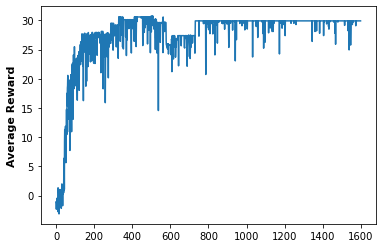

In [14]:
# Plotting average rewards
# x-values = 0000 episodes tracked after every 25th episode
plt.plot(list(range(len(avg_reward))), avg_reward)
plt.ylabel("Average Reward",fontsize=11.0, fontweight='bold')
plt.show()


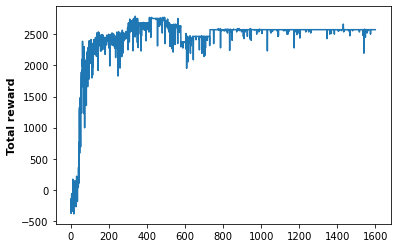

In [15]:
# Plotting total rewards
plt.plot(list(range(len(total_rewards))), total_rewards)
plt.ylabel("Total reward",fontsize=11.0, fontweight='bold')
plt.show()

## Checking Q-values

In [23]:
States_track

defaultdict(dict,
            {(1,
              0,
              2): {(2, 1): [2572.866,
               453695.44,
               267297.56,
               136282.53,
               48337.69,
               10100.897,
               1232.5706,
               530.5932,
               839.16125,
               60682.76,
               7014.1753,
               1611.1285,
               23350.803,
               12635.5625,
               18762.473,
               4792.542,
               3525.345,
               1193.8856,
               663.46655,
               17164.568,
               705.6745,
               229.77713,
               885.0924,
               0.0,
               1202.2181,
               820.05383,
               477.04688,
               611.059,
               0.0,
               54.89112,
               250.91106,
               327.42734,
               565.0995,
               219.66986,
               214.35039,
               216.57634,
               3974.21

<function matplotlib.pyplot.show(close=None, block=None)>

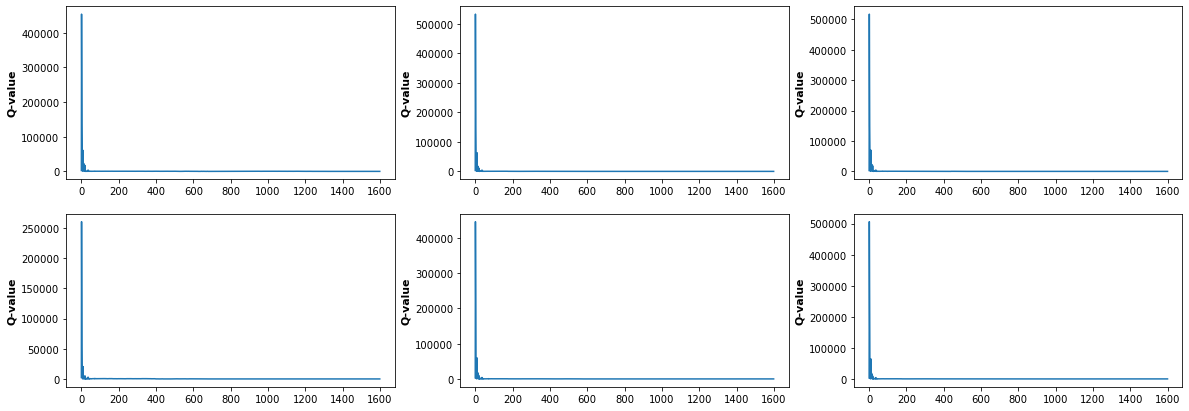

In [16]:
plt.figure(0, figsize=(20,7))

xaxis = np.asarray(range(len(States_track[(1,0,2)][(2,1)])))
plt.subplot(231)
plt.plot(xaxis,np.asarray(States_track[(1,0,2)][(2,1)]))
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(len(States_track[(2,6,3)][(1,3)])))
plt.subplot(232)
plt.plot(xaxis,np.asarray(States_track[(2,6,3)][(1,3)]))
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(len(States_track[(3,3,2)][(4,2)])))
plt.subplot(233)
plt.plot(xaxis,np.asarray(States_track[(3,3,2)][(4,2)]))
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(len(States_track[(5,11,6)][(3,4)])))
plt.subplot(234)
plt.plot(xaxis,np.asarray(States_track[(5,11,6)][(3,4)]))
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(len(States_track[(0,20,3)][(1,3)])))
plt.subplot(235)
plt.plot(xaxis,np.asarray(States_track[(0,20,3)][(1,3)]))
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(len(States_track[(1,20,3)][(1,3)])))
plt.subplot(236)
plt.plot(xaxis,np.asarray(States_track[(1,20,3)][(1,3)]))
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show


## Zoomed Last 200 Q values

<function matplotlib.pyplot.show(close=None, block=None)>

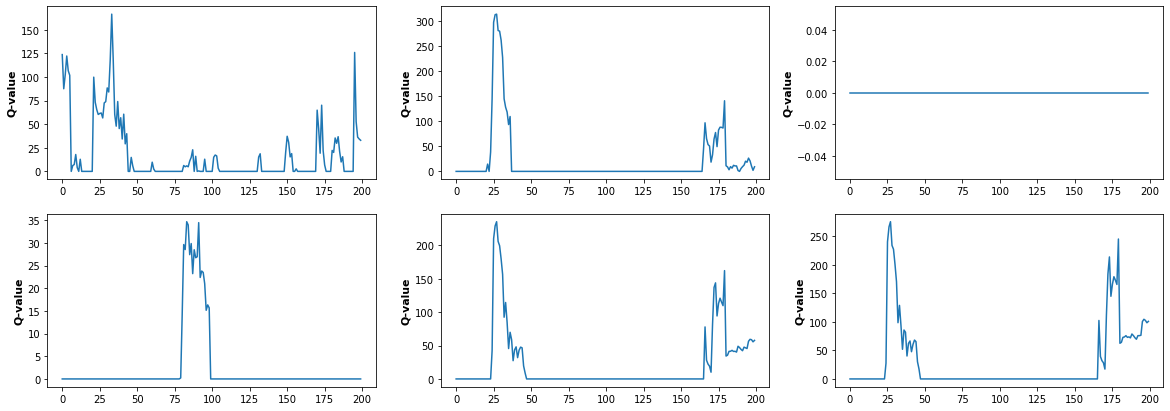

In [20]:
plt.figure(0, figsize=(20,7))

xaxis = np.asarray(range(200))
plt.subplot(231)
plt.plot(xaxis,np.asarray(States_track[(1,0,2)][(2,1)])[-200:])
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(200))
plt.subplot(232)
plt.plot(xaxis,np.asarray(States_track[(2,6,3)][(1,3)])[-200:])
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(200))
plt.subplot(233)
plt.plot(xaxis,np.asarray(States_track[(3,3,2)][(4,2)])[-200:])
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(200))
plt.subplot(234)
plt.plot(xaxis,np.asarray(States_track[(5,11,6)][(3,4)])[-200:])
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(200))
plt.subplot(235)
plt.plot(xaxis,np.asarray(States_track[(0,20,3)][(1,3)])[-200:])
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(200))
plt.subplot(236)
plt.plot(xaxis,np.asarray(States_track[(1,20,3)][(1,3)])[-200:])
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

### Interpreting Q values

In [25]:
state_encod = env.state_encod_arch1([3,3,2])
state_encod = np.reshape(state_encod, [1, agent.state_size])
prediction = agent.model.predict(state_encod)
actions = env.action_space

In [26]:
dict = {}
for i,j in enumerate(actions):
    dict[tuple(j)]=prediction[0][i]
    
print(dict)
print(max(dict,key=dict.get))

{(0, 0): 0.0, (0, 1): 10.023711, (0, 2): 242.09055, (0, 3): 0.0, (0, 4): 0.0, (1, 0): 0.0, (1, 2): 422.1287, (1, 3): 91.73658, (1, 4): 0.0, (2, 0): 202.43997, (2, 1): 0.0, (2, 3): 0.0, (2, 4): 36.761963, (3, 0): 129.18633, (3, 1): 0.0, (3, 2): 394.22763, (3, 4): 0.0, (4, 0): 0.0, (4, 1): 0.0, (4, 2): 0.0, (4, 3): 200.06528}
(1, 2)


#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [21]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

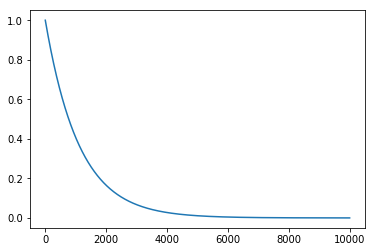

In [7]:
plt.plot(time, epsilon)
plt.show()

<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:red' role="tab" aria-controls="home"><center>Thank You! 😊</center></h2>
